In [1]:
from model import *

In [11]:
def train_eval_model(df, target_variable='change in followers'):
    train_df, val_df, test_df, num_features = data_process(df)
    column_indices = {name: i for i, name in enumerate(df.columns)}
    baseline = Baseline(label_index=column_indices[target_variable])

    baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                    metrics=[tf.keras.metrics.MeanAbsoluteError()])

    val_performance = {}
    performance = {}
    single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1, train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[target_variable])
    val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
    performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)
    
    num_weeks = 26
    wide_window = WindowGenerator(
    input_width=num_weeks, label_width=num_weeks, shift=1, train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[target_variable])
    wide_window.plot(baseline)
    
    print(f"Baseline MAE: {performance['Baseline']['mean_absolute_error']}")
    print(f"Performance: {performance}")
    print(f"Validation Performance: {val_performance}")
    
    return "SingleBaseline", baseline, wide_window

In [3]:
from utilities import *
df = clean_data()[0]
df = derivatives_data(df)[0]
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 231658 entries, 21 to 298039
Data columns (total 7 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   period_end_date                         231658 non-null  datetime64[ns]
 1   business_entity_doing_business_as_name  231658 non-null  object        
 2   change in pictures                      231658 non-null  float64       
 3   change in videos                        231658 non-null  float64       
 4   change in comments                      231658 non-null  float64       
 5   change in likes                         231658 non-null  float64       
 6   change in followers                     231658 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 14.1+ MB


In [4]:
df_versace = df[df['business_entity_doing_business_as_name'] == 'Versace'].drop(columns=['business_entity_doing_business_as_name'])
df_versace.info()

<class 'pandas.core.frame.DataFrame'>
Index: 455 entries, 283298 to 283752
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   period_end_date      455 non-null    datetime64[ns]
 1   change in pictures   455 non-null    float64       
 2   change in videos     455 non-null    float64       
 3   change in comments   455 non-null    float64       
 4   change in likes      455 non-null    float64       
 5   change in followers  455 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 24.9 KB


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 1.1353 - mean_absolute_error: 0.9533
Baseline MAE: 0.8463432192802429
Performance: {'Baseline': {'loss': 0.9164581298828125, 'mean_absolute_error': 0.8463432192802429}}
Validation Performance: {'Baseline': {'loss': 1.1256496906280518, 'mean_absolute_error': 0.9476559162139893}}


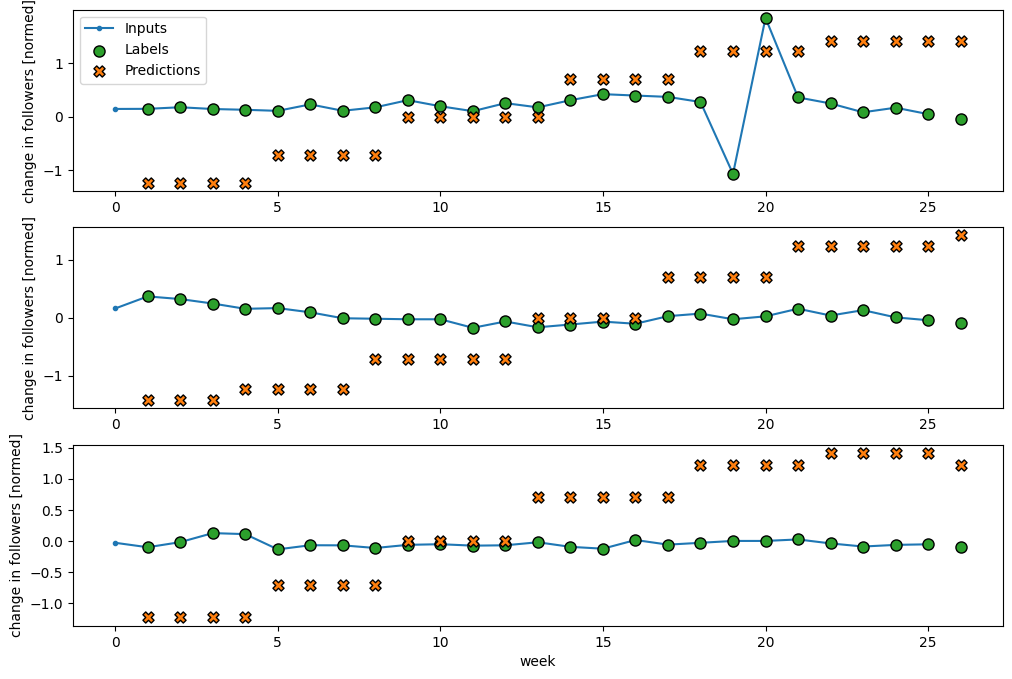

In [12]:
best_model_name, best_model, window = train_eval_model(df_versace)


In [13]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [15]:
train_df, val_df, test_df, num_features = data_process(df_versace)

In [21]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

def plot(self, model=None, plot_col='change in followers', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('week')

WindowGenerator.plot = plot

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [22]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1, train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=['change in followers'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['change in followers']

In [23]:
column_indices = {name: i for i, name in enumerate(df_versace.columns)}
baseline = Baseline(label_index=column_indices['change in followers'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 1.0721 - mean_absolute_error: 0.9207


In [24]:
num_weeks = 26
wide_window = WindowGenerator(
    input_width=num_weeks, label_width=num_weeks, shift=1, train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=['change in followers'])

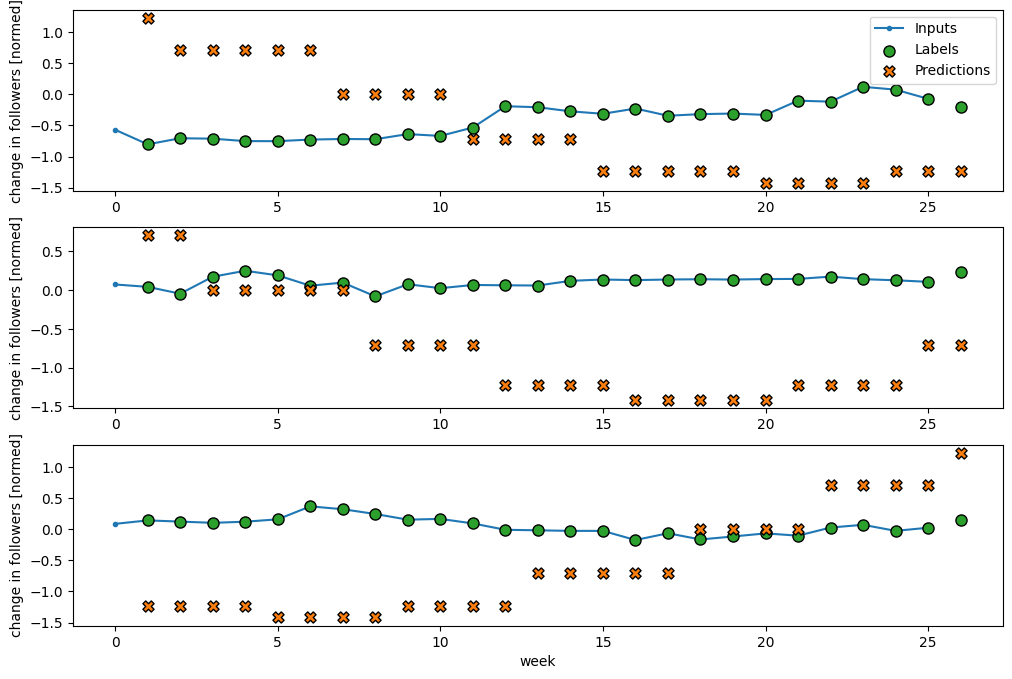

In [25]:
wide_window.plot(baseline)